* By: Illya Barziy
* Email: illyabarziy@gmail.com
* Reference: __A Robust Estimator of the Efficient Frontier__ _by_ Marcos Lopez de Prado

## The Nested Clustered Optimization algorithm (NCO)

This description of the algorithm and the realizations in the mlfinlab package are based on the paper by _Marcos Lopez de Prado_ __A Robust Estimator of the Efficient Frontier__  [available here](https://papers.ssrn.com/abstract_id=3469961).

## Introduction

Convex optimization solutions in the problems of portfolio optimization tend to be unstable. The instability comes from two sources:
- Noise in the input variables
- The signal structure that magnifies the estimation errors in the input variables

The NCO algorithm tackles both sources of instability.

### Problem Statement

This part is a direct quote from the paper __A Robust Estimator of the Efficient Frontier__ with minor comments.

Say, we have a system with $N$ random variables, the expected value of draws of the variables are $\mu$ and the covariance matrix is $V$. We want to compute the vector $w$ that minimizes the variance of the system, where the variance is $w'Vw$, subject to $w'a$. Here $a$ characterizes the optimal solution. 

So, the problem is:

$$min_{w}\frac{1}{2}w'Vw$$

$$s.t.: w'a = 1 $$

In financial application, the optimal allocation $w^*$ known as the maximum Sharpe ratio, when $a = \mu$ (as it maximizes $\frac{w'\mu}{\sqrt{w'Vw}}$).

The optimal allocation $w^*$ known as the minimum variance portfolio, when $a = 1_{N}$, where $1_{N}$ is the vector of ones of size $N$ (as it minimizes the $w'Vw$ - variance).


Using the convex optimization methods, the optimal solution to the problem is

$$w^* = \frac{V^{-1}a}{a'V^{-1}a}$$

This is the Convex Optimization Solution (CVO). It allows finding the optimal weights $w$, when the real $V$ and $a$ of the variables are known.

As the input variables $V$ and $a$ are typically unknown, the estimations are used, which leads to unstable solutions where a small change of inputs will cause bix changes of $w^*$.

The estimators are obtained from observations (draws) of $N$ variables, or instruments in a portfolio.

### Instability caused by noise

This part is a direct quote from the paper __A Robust Estimator of the Efficient Frontier__ with minor comments.

We have a matrix of i.i.d. random observations $X$, of size $TxN$. The underlying process is generating the observations with zero mean and $\sigma^2$ variance. 

The matrix $C = T^{-1}X'X$ has eigenvalues $\lambda$ that asymptotically converge (as $N \rightarrow +\infty$ and $T \rightarrow +\infty$ with $1 < \frac{T}{N} < +\infty$) to the Marcenko-Pastur probability density function:

$$ f[\lambda] =
  \begin{cases}
    \frac{T}{N}\frac{\sqrt{(\lambda_+-\lambda)(\lambda-\lambda_-)}}{2\pi\lambda\sigma^2} & \quad \text{if } i \in [\lambda_-,\lambda_+] \text{,}\\
    0  & \quad \text{if } i \notin [\lambda_-,\lambda_+] \text{.}
  \end{cases}$$

Where the maximim expected eigenvalue is 

$$\lambda_+ = \sigma^2(1 + \sqrt{\frac{N}{T}})^2$$

and the minimum expected eigenvalue is 

$$\lambda_- = \sigma^2(1 - \sqrt{\frac{N}{T}})^2$$

When $\sigma^2 = 1$, then $C$ is the correlation matrix associated with $X$.

The Marcenko-Pastur distribution explains why empirical covariance matrices contain substantial amounts of noise. 

In many practical applications, $\frac{N}{T}\rightarrow 1$, thus the covariance's eigenvalues span a wide range $[\lambda_-,\lambda_+]$. Because $\lambda_- \rightarrow 0$ as $\frac{N}{T}\rightarrow 1$, the determinant of $V$ approaches zero and $V^{-1}$ cannot be estimated robustly, this is the source of unstable solutions $w^*$

The process of de-noising the covariance matrix that is used in the code examples in the end is described in a paper by _Potter M._, _J.P. Bouchaud_, _L. Laloux_ __“Financial applications of random matrix theory: Old laces and new pieces.”__  [available here](https://arxiv.org/abs/physics/0507111).

It is briefly explained later in the notebook.

### Instability caused by signal

This part is a direct quote from the paper __A Robust Estimator of the Efficient Frontier__ with minor comments.

Certain covariance structures can make the optimal solution unstable. Looking at the correlation matrix between two variables:

$$C =
  \begin{bmatrix}
    1 & \rho\\
    \rho & 1 
  \end{bmatrix}$$

Where the $\rho$ is the correlation between their outcomes. Matrix $C$ can be diagonalized as $CW = W\Lambda$, where

$$\Lambda = 
  \begin{bmatrix}
    1 & +\rho \\
    1 & -\rho 
  \end{bmatrix}$$

$$W = 
  \begin{bmatrix}
    \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} \\
    \frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}} 
  \end{bmatrix}$$

The inverse of $C$ is

$$C^{-1}=W\Lambda^{-1}W'=\frac{1}{|C|} =
  \begin{bmatrix}
    1 & -\rho \\
    -\rho & 1 
  \end{bmatrix}$$

Where $|C|$ is the determinant of $C$, $|C|=(1+\rho)(1-\rho)=1-\rho^2$.

We can see that more $\rho$ derives from zero, the bigger one eigenvalue becomes relative to the other, causing the determinant of $C$ to approach zero, which makes the values of $C^{-1}$ explode.

When the correlation matrix is an identity matrix, the eigenvalue function is a horizontal line. Outside that ideal case, at least one subset of variables exhibits greater correlation among themselves than to the rest, forming a cluster within the correlation matrix. 

When $K$ variables form a cluster, they are more heavily exposed to a common eigenvector, which implies that the associated eigenvalue explains a greater amount of variance. 

But because the trace of the correlation matrix is exactly $N$, that means that an eigenvalue can only increase at the expense of the other $K-1$ eigenvalues in that cluster, resulting in a condition number greater than 1. Consequently, the greater the intra-cluster correlation is, the higher the condition number becomes. 

### De-noising function

The function provided below for de-noising the covariance works as follows:
- The given covariance matrix is transformed to the correlation matrix.
- The eigenvalues and eigenvectors of the correlation matrix are calculated.
- Using the Kernel Density Estimate algorithm a kernel of the eigenvalues is estimated.
- The Marcenko-Pastur pdf is fitted to the KDE estimate using the variance as the parameter for the optimization.
- From the obtained Marcenko-Pastur distribution, the maximum theoretical eigenvalue is calculated using the formula from the "Instability caused by noise" part.
- The eigenvalues in the set that are above the theoretical value are all set to their average value. For example, we have a set of 5 sorted eigenvalues ($\lambda_1$...$\lambda_5$), 2 of which are above the maximum theoretical value, then we set $\lambda_4^{NEW} = \lambda_5^{NEW} = \frac{\lambda_4^{OLD} + \lambda_5^{OLD}}{2}$
- The new set of eigenvalues with the set of eigenvectors is used to obtain the new de-noised correlation matrix.
- The new correlation matrix is then transformed back to the new de-noised covariance matrix.

This is how the de-noising function from mlfinlab package can be used:

In [2]:
import mlfinlab as ml
import numpy as np

In [3]:
# A class that has the de-noising function
risk_estimators = ml.portfolio_optimization.RiskEstimators()

# Covariance matrix to de-noise
cov_matrix = np.array([[0.01, 0.002, -0.001],
                       [0.002, 0.04, -0.006],
                       [-0.001, -0.006, 0.01]])

# Relation of number of observations T to the number of variables N (T/N)
tn_relation = 50

# The bandwidth of the KDE kernel
kde_bwidth = 0.25

# Finding the de-noised covariance matrix
cov_matrix_denoised = risk_estimators.denoise_covariance(cov_matrix, tn_relation, kde_bwidth)

# Outputting the result
print('The de-noised covariance matrix is:')
print(cov_matrix_denoised)

The de-noised covariance matrix is:
[[ 0.01        0.00267029 -0.00133514]
 [ 0.00267029  0.04       -0.00438387]
 [-0.00133514 -0.00438387  0.01      ]]


As we can see, the main diagonal hasn't changed, but the other covariances are different. This means that the algorithm has changed the eigenvalues of the correlation matrix.

Also functions to:
- transform covariance matrix into correlation matrix 
- transform correlation matrix into covariance matrix 

are available in the mlfinlab package:

In [4]:
# Transforming our covariance matrix to a correlation matrix
corr_matrix = risk_estimators.cov_to_corr(cov_matrix)

# Outputting the result
print('The correlation matrix is:')
print(corr_matrix)

# The standard deviation to use when calculating the covaraince matrix back
std = np.array([0.1,0.2,0.1])

# And back to the covariance matrix
cov_matrix_again = risk_estimators.corr_to_cov(corr_matrix, std)

# Outputting the result
print('The covariance matrix calculated back is:')
print(cov_matrix_again)
print('Exactly the same as the original one:')
print(cov_matrix)


The correlation matrix is:
[[ 1.   0.1 -0.1]
 [ 0.1  1.  -0.3]
 [-0.1 -0.3  1. ]]
The covariance matrix calculated back is:
[[ 0.01   0.002 -0.001]
 [ 0.002  0.04  -0.006]
 [-0.001 -0.006  0.01 ]]
Exactly the same as the original one:
[[ 0.01   0.002 -0.001]
 [ 0.002  0.04  -0.006]
 [-0.001 -0.006  0.01 ]]


### NCO and CVO functions

The Convex Optimization Solution (CVO) solves the problem described in the "Problem Statement" part using the provided formula:

$w^* = \frac{V^{-1}a}{a'V^{-1}a}$

The NCO algorithm is following these steps:

- Gets the covariance matrix of the outcomes as an input (and the vector of means if the target is to maximize the Sharpe ratio).
- Transforms the covariance matrix to the correlation matrix and calculate the distance matrix based on it.
- Clusters the covariance matrix into subsets of highly-correlated variables.
- Computes the optimal weights allocation for every cluster (using the CVO).
- Reduces the original covariance matrix to a reduced one - where each cluster is represented by a single variable.
- Computes the optimal weights allocation for the reduced covariance matrix (using the CVO).
- Computes the final allocations as a dot-product of the allocations between the clusters and inside the clusters.


This is how the NCO and the CVO from mlfinlab package can be used:

In [5]:
# A class that has the NCO and CVO functions
nco = ml.portfolio_optimization.NCO()

# Covariance matrix
cov_matrix = np.array([[0.01, 0.002, -0.001],
                       [0.002, 0.04, -0.006],
                       [-0.001, -0.006, 0.01]])

# Vector of ones (as our goal is minimizing the variance)
mu_vec = np.array([1, 1, 1]).reshape(-1, 1)

# Maximum number of clusters to use in the correlation matrix clustering
max_num_clusters = 2

# Finding the optimal weights using the NCO
w_nco = nco.allocate_nco(cov_matrix, mu_vec, max_num_clusters=max_num_clusters)

# Outputting the result
print('The optimal weights with minimum variance using the NCO are:')
print(w_nco)

The optimal weights with minimum variance using the NCO are:
[[0.43298969]
 [0.13402062]
 [0.43298969]]


Now using the simple CVO algorithm:

In [6]:
# Finding the optimal weights using the CVO
w_cvo = nco.allocate_cvo(cov_matrix, mu_vec)

# Outputting the result
print('The optimal weights with minimum variance using the CVO are:')
print(w_cvo)

The optimal weights with minimum variance using the CVO are:
[[0.37686939]
 [0.14257228]
 [0.48055833]]


The results are different, so the NCO has clustered the correlation matrix. We can see in later examples if this produces a more robust result.

### MCOS function

The Monte Carlo Optimization Selection (MCOS) algorithm calculates the NCO allocations and a simple optimal allocation for multiple simulated pairs of mean vector and the covariance matrix to determine the most robust method for weights allocations for a given pair of means vector and a covariance vector. Basically, it will show if the NCO or the CVO method is more robust.

However, the MCOS may support other optimization methods and compare their robustness.

The steps of the MCOS algorithm are:
- Gets the covariance matrix and the means vector of the true outcomes as an input (along with the simulation parameters to use).
- Draws the empirical covariance matrix and the empirical means vector based on the true ones.
- If the kde_bwidth parameter is given, the empirical covariance matrix is de-noised.
- Based on the min_var_portf parameter, either the minimum variance or the maximum Sharpe ratio is targeted in weights allocation.
- CVO is applied to the empirical data to obtain the weights allocation.
- NCO is applied to the empirical data to obtain the weights allocation.
- Based on the original covariance matrix and the means vector a true optimal allocation is calculated.
- For each weights estimation in a method, a standard deviation between the true weights and the obtained weights from the simulation is calculated.
- The error associated with each method is calculated as the mean of the standard deviation across all estimations for the method.

This is how the MCOS from mlfinlab package can be used:

In [7]:
# Covariance matrix
cov_mat = np.array([[1, 0.1, 0.2, 0.3],
                    [0.1, 1, 0.1, 0.2],
                    [0.2, 0.1, 1, 0.1],
                    [0.3, 0.2, 0.1, 1]])

# Vector of means
mu_vec = np.array([0, 0.1, 0.2, 0.3])

# Number of observations to use to obtain empirical covariance matrix and the means vector
num_obs = 100

# Number of simulations to do in the MCOS
num_sims = 2

# The bandwidth of the KDE kernel.
kde_bwidth = 0.25

# Flag if the goal is the minimum variance
min_var_portf = True

# Flag if we want to use the Ledoit-Wolf shrinkage procedure
lw_shrinkage = False

# For the same result output
np.random.seed(1)

# Finding the optimal weights for minimum variance
w_cvo, w_nco = nco.allocate_mcos(mu_vec, cov_mat, num_obs, num_sims, kde_bwidth, min_var_portf, lw_shrinkage)

# Outputting the result
print('The optimal weights with minimum variance using the NCO from simulations are:')
print(w_nco)
print('The optimal weights with minimum variance using the CVO from simulations are:')
print(w_cvo)

The optimal weights with minimum variance using the NCO from simulations are:
          0         1         2         3
0  0.181431  0.326042  0.165669  0.326857
1  0.221613  0.394977  0.204978  0.178432
The optimal weights with minimum variance using the CVO from simulations are:
          0         1         2         3
0  0.165431  0.344039  0.168434  0.322096
1  0.202771  0.427418  0.212893  0.156919


And the outputs can be analyzed based on the mean of the standard deviation with the true weight allocations.

In [8]:
# Finding the errors in estimations
err_cvo, err_nco = nco.estim_errors_mcos(w_cvo, w_nco, mu_vec, cov_mat, min_var_portf)

# Outputting the result
print('The mean of the standard deviation with the true weight for NCO is:')
print(err_nco)
print('The mean of the standard deviation with the true weight for CVO is:')
print(err_cvo)

The mean of the standard deviation with the true weight for NCO is:
0.0524762395749268
The mean of the standard deviation with the true weight for CVO is:
0.05839900155706323


Even on this small example, we can see that the NCO has performed better than the CVO method (the error metric is smaller).

### Sample Data Generating function

We can create a random vector of means and a random covariance matrix to properly test the algorithms described above. 

These created covariance matrix and vector of means have similar characteristics to what the real securities inside a portfolio may pose. 

The elements are divided into clusters. The elements in clusters have a given level of correlation. The correlation between the clusters is set at another level. This structure is created in order to test the NCO and MCOS algorithms.

This is how the Sample Data Generating function from mlfinlab package can be used:

In [9]:
# Number of blocks to have in a modeled matrix
num_blocks = 2

# The size of each block in a modeled matrix
block_size = 2

# Correlation inside a block
block_corr = 0.3

# Correlation between the clusters
std = 0.3

# Finding the random vector of means and covariance matrix
mu_vec, cov_matrix = nco.form_true_matrix(num_blocks, block_size, block_corr, std)

# Outputting the result
print('The generated vector of means is:')
print(mu_vec)
print('The generated covariance matrix is:')
print(cov_matrix)

The generated vector of means is:
[[-0.00089985]
 [ 0.2608328 ]
 [ 0.45695781]
 [ 0.0015997 ]]
The generated covariance matrix is:
       0      3      2      1
0  0.090  0.000  0.000  0.027
3  0.000  0.090  0.027  0.000
2  0.000  0.027  0.090  0.000
1  0.027  0.000  0.000  0.090


This covariance vector and matrix of means can be used to test the NCO and the CVO methods.

### Output visualization

Let's use all of the described above functions on a bigger set of generated data and visualize the results.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

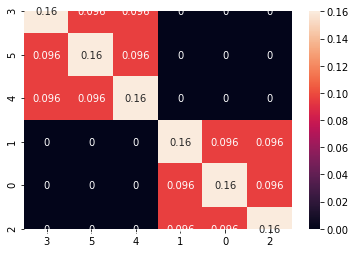

In [11]:
# Number of blocks (clusters in a matrix)
num_blocks = 2

# The size of each block (cluster) in a modeled matrix
block_size = 3

# Correlation inside a block
block_corr = 0.6

# Correlation between the clusters
std = 0.4

# For the same result output
np.random.seed(3)

# Finding the random vector of means and covariance matrix
mu_vec, cov_matrix = nco.form_true_matrix(num_blocks, block_size, block_corr, std)

#Plotting the heatmap
sns.heatmap(cov_matrix, annot=True)

The result is a covariance matrix with exactly 2 blocks (clusters) that have 3 elements each.

As the function shuffles the resulting covariance matrix, in other outputs of the function the block structure may not be seen so clearly as in this example. 

This covariance matrix and vector of means can be used to run the MCOS algorithm.

In [12]:
# Number of observations to use to obtain empirical covariance matrix and the means vector
num_obs = 100

# Number of simulations to do in the MCOS
num_sims = 50

# The bandwidth of the KDE kernel.
kde_bwidth = 0.25

# Flag if the goal is the minimum variance
min_var_portf = True

# Flag if we want to use the Ledoit-Wolf shrinkage procedure
lw_shrinkage = False

# For the same result output
np.random.seed(1)

# Finding the optimal weights for minimum variance
w_cvo, w_nco = nco.allocate_mcos(mu_vec, cov_matrix, num_obs, num_sims, kde_bwidth, min_var_portf, lw_shrinkage)

The result is a DataFrame of weigths of NCO and CVO for every simulation. We can make boxplots to examine the differences in the results.

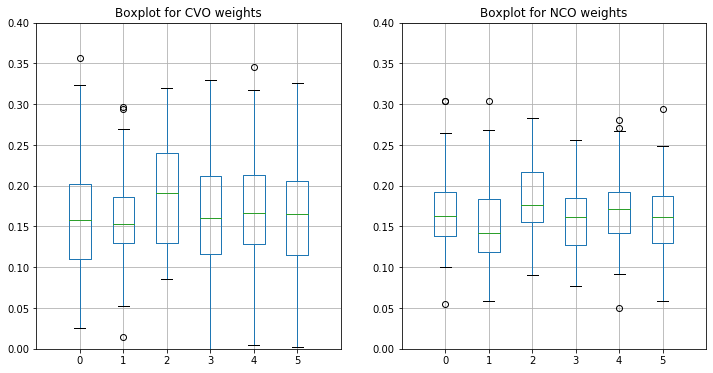

In [13]:
# Creating subplot figure with having two side by side plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# Plot the boxplot of CVO weigths
w_cvo.boxplot(ax = axes[0]) 
axes[0].set_title('Boxplot for CVO weights')

# Setting the same grid size
axes[0].set_xlim(0, 7)
axes[0].set_ylim(0, 0.4)

# Plot the boxplot of NCO weigths
w_nco.boxplot(ax = axes[1])
axes[1].set_title('Boxplot for NCO weights')

# Setting the same grid size
axes[1].set_xlim(0, 7)
axes[1].set_ylim(0, 0.4)

# Plot the result
plt.show()

The weigths produced by the NCO are grouped at higher density near the mean values (have a lower variance of weights).

This would mean that the NCO has produced more robust estimates of the optimal weights allocation.

We can check it by calculating the mean of the standard deviation between the weights of the method and the true optimal allocation.

In [14]:
# Finding the errors in estimations
err_cvo, err_nco = nco.estim_errors_mcos(w_cvo, w_nco, mu_vec, cov_matrix, min_var_portf)

# Outputting the result
print('The mean of the standard deviation with the true weight for NCO is:')
print(err_nco)
print('The mean of the standard deviation with the true weight for CVO is:')
print(err_cvo)

The mean of the standard deviation with the true weight for NCO is:
0.04621200914715077
The mean of the standard deviation with the true weight for CVO is:
0.06902384964077275


Indeed, the error of the NCO is much lower than the error from simple CVO.

### Conclusion

This notebook describes the Nested Clustered Optimization (NCO) algorithm, the Monte Carlo Optimization Selection (MCOS) algorithm alongside the De-noising algorithm and other helping functions. Also, it shows how these can be used on some real examples.

The algorithms and the descriptions were originally presented by _Marcos Lopez de Prado_ in the paper __A Robust Estimator of the Efficient Frontier__  [available here](https://papers.ssrn.com/abstract_id=3469961).

Key takeaways from the notebook:
- Convex optimization solutions in the problems of portfolio optimization tend to be unstable.
- The instability comes from two sources
  - Noise in the input variables
  - The signal structure that magnifies the estimation errors in the input variables
- The De-noising algorithm calculates the eigenvalues of the correlation matrix and eliminates the ones that are higher than the theoretically estimated ones, as they are caused by noise.
- The Convex Optimization Solution (CVO) can either find optimal allocations for maximum Sharpe ratio or minimum variance.
- The Nested Clustered Optimization (NCO) breaks the correlation matrix into clusters and applies CVO individually to each cluster as well as to the correlation matrix where each element represents a cluster.
- The Monte Carlo Optimization Selection (MCOS) allows running optimization methods (in our case CVO and NCO) on multiple sets of empirical covariation matrices and empirical vectors of means. It can show which method is more robust.
- The Sample Data Generating function can be used to get a covariance matrix that has distinct clusters with correlations inside a cluster and different correlations between clusters.